### 시스템트레이딩 로직
    1. 5분봉, 과거 20개 기준 평균 및 표준편차 기반 시그널 계산 ( +2 std, -2 std)
    2. 현재 투자 유니버스 현선물 비율 계산 및 괴리율 높은 페어 선정
    3. 익절 및 손절 기준 현선물 비율 계산
    4. 포지션 진입

### 투자 유니버스 선정
    1. 바이낸스에 없는 티커 제거
    2. 비정상적인 현선비율 페어의 경우 제거
    3. BNB(바이낸스코인)의 경우 수수료 목적으로 사용하므로 제외 
    4. 최소 주문수량 10 usdt 이상인 경우 제외

### 현물 종가 크롤링

### 시그널 생성

### 현재 현선비율 계산

### 수수료 계산
    # 예상 수수료(BNB+리베이트+지정가): 매입현물(6bp) + 매입선물(1.8bp) + 매도현물(6bp) + 매도선물(1.8bp) = 15.6
    # 예상 수수료(BNB+리베이트+시장가): 매입현물(6bp) + 매입선물(3.6bp) + 매도현물(6bp) + 매도선물(3.6bp) = 19.2
    
### 익절 및 손절 기준 계산 (현선비율)
    현선물 비율은 10bp 정도로 움직이는 것으로 파악됨

    익절기준: +25bp 수익률일 때의 현선비율 (순수익 6bp = 25bp - 19bp)
    손절기준: -30bp 수익률일 때의 현선비율 (순손실 -11bp = 30bp - 19bp) 
    
    <확률 계산>
    # 9번 승리: 54bp
    # 1번 패배: -30bp

### 포지션 청산
    1. 잔고에 있는 페어 모니터링
    2. (현물) 해당 코인 > 10 usdt 이상 있을때
    3. (선물) 해당 코인 미실현수익률이 0이 아닐때
    4. 익절 혹은 손절 기준 터치시)
        현물 매도 & 선물 매수 (시장가)

### 포지션 진입
    1. (현물) 현물 usdt 11 이상 & 잔고에 해당 현물 코인이 usdt 9 미만인 경우
    2. (선물) 선물 usdt 11 이상 & 해당 선물 코인 미실현 수익률이 0인 경우
    3. 현선배율 negative 시그널 미만)
        -> 현물 매수 & 선물 매도
        
    * 모니터링 필요 데이터 (진입 시점, 포지션, 티커, 매수/매도금액)

### 모듈 임포트

In [1]:
import ccxt
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import timezone
import pytz
from sympy import Symbol, solve 

### API 설정 및 투자유니버스 선정

In [2]:
api_key = 'OgxD57rhXgkWPCwhTGJ8vYBAntjTqonog9WSzk5OAqDWK9o7iLOPbyeJojbiwlVr'
secret = 'SGl7Bd6fIraNXvqCHd8nS4LYisEkZ2QUw64Z4t2pYjIm0dUtsffBs4kMnzmjvgoN'

binance = ccxt.binance(config={
    'apiKey': api_key,
    'secret': secret
})


binance_f = ccxt.binance(config={
    'apiKey': api_key,
    'secret': secret,
    'options': {
        'defaultType': 'future'
    }
})

ticker_list = list(binance.fetch_tickers().keys())
ticker_list = list(pd.Series(map(lambda x : x if x[4:] == 'USDT' else np.nan, ticker_list)).dropna())

num = 0
error_ticker = []

for ticker in ticker_list : 
    
    try:
        btc_ohlcv = binance.fetch_ohlcv(ticker)
        btc_f_ohlcv = binance_f.fetch_ohlcv(ticker)
        
    except ccxt.BadSymbol as e:
        error_ticker.append(str(e))

error_ticker_revised = list(map(lambda x: x[36:45], error_ticker))

final_list = list(set(ticker_list) - set(error_ticker_revised))
final_list.remove('BCH/USDT')
final_list.remove('BNB/USDT')
final_list.remove('AXS/USDT')
final_list.remove('HNT/USDT')
final_list.remove('BTC/USDT')
# 최소수량 1SOL = 33.93 USDT (2021-08-01 기준)
final_list.remove('SOL/USDT')
# 최소수량 0.1KSL = 19.26 USDT (2021-08-01 기준)
final_list.remove('KSM/USDT')
# 최소수량 1UNI = 21.22 USDT (2021-08-01 기준)
final_list.remove('UNI/USDT')
# 최소수량 0.001YFI = 33.35 USDT (2021-08-01 기준)
final_list.remove('YFI/USDT')

### 함수정리

In [37]:
def get_close(exchange, ticker, freq, num, start_) :
    ohlcv_ =  np.array(exchange.fetch_ohlcv(ticker, freq, since = start_, limit = num))
    if len(ohlcv_) != num :
        date_ = np.array([np.nan] * num)
        close_ = np.array([np.nan] * num)
    else :
        date_ = ohlcv_[:, 0]
        close_ = ohlcv_[:, 4]
    return date_, close_

def get_close(exchange, ticker, freq, num, start_) :
    ohlcv_ =  np.array(exchange.fetch_ohlcv(ticker, freq, since = start_, limit = num))
    if len(ohlcv_) != num :
        date_ = np.array([np.nan] * num)
        close_ = np.array([np.nan] * num)
    else :
        date_ = ohlcv_[:, 0]
        close_ = ohlcv_[:, 4]
    return date_, close_

def get_all_close(exchange, ticker_list, freq, num, start_) :
    date = get_close(exchange, ticker_list[0], freq, num, start_)[0]
    close_1 = get_close(exchange, ticker_list[0], freq, num, start_)[1]
    all_close_ = [date, close_1]

    for ticker_ in ticker_list[1:] : 
        tmp_close = get_close(exchange, ticker_, freq, num, start_)[1]
        all_close_.append(tmp_close)
        time.sleep(0.1)

    all_close_ = np.stack(all_close_, axis=1)
    print('모든 종가 추출 완료')
    
    return all_close_

def price_goal_eq(ticker, close_, goal) :
    x=Symbol('x')
    equation = ((x - close_) / close_) - goal
    price_goal = solve(equation)[0]
    return price_goal

def cal_pro_loss_cut(ticker, close__, close_f_) :
    curr_close_tmp = close__[ticker]
    curr_close_f_tmp = close_f_[ticker]

    curr_ratio_ = curr_close_tmp / curr_close_f_tmp
    profit_cut = float(price_goal_eq(ticker, curr_close_tmp, 0.0025)) / curr_close_f_tmp
    loss_cut = float(price_goal_eq(ticker, curr_close_tmp, -0.003)) / curr_close_f_tmp
    return profit_cut, loss_cut, curr_ratio_

def get_pro_loss_df(list_) :
    profit_cut_list = []
    loss_cut_list = []
    curr_ratio_list = []
    
    for ticker in list_ :
        profit_tmp, loss_tmp, curr_ratio_tmp = cal_pro_loss_cut(ticker, curr_close, curr_close_f)
        profit_cut_list.append(profit_tmp)
        loss_cut_list.append(loss_tmp)
        curr_ratio_list.append(curr_ratio_tmp)
    
    pro_loss_df = pd.DataFrame()
    pro_loss_df['ticker'] = list_
    pro_loss_df['ratio'] = curr_ratio_list
    pro_loss_df['profit'] = profit_cut_list
    pro_loss_df['loss'] = loss_cut_list
    pro_loss_df.set_index('ticker', inplace = True)
    
    return pro_loss_df

def cal_q(_close_, ticker_f_3, goal_usdt) :
    x=Symbol('x')
    equation = _close_[ticker_f_3 + '/USDT'] * x - goal_usdt
    quantity_ = float(solve(equation)[0])
    return quantity_

###################################
# get_num = 분봉 가져올 갯수
# ccxt는 utc(세계표준시간)에 int 타입을 사용
###################################
def cal_ratio_signal(get_num) :

    bef_m = datetime.fromtimestamp(binance.milliseconds() / 1000) - timedelta(seconds = 60 * get_num)
    start = binance.parse8601(bef_m.astimezone(pytz.utc).isoformat(sep=' ',timespec='milliseconds'))

    all_close = get_all_close(binance, final_list, '1m', get_num, start)
    all_close_f = get_all_close(binance_f, final_list, '1m', get_num, start)

    ratio = pd.DataFrame(all_close / all_close_f)
    ratio.columns = ['date'] + final_list
    ratio['date'] = all_close[:,0]
    ratio['date'] = pd.to_datetime(ratio['date'], unit='ms') + timedelta(hours = 9)
    ratio.set_index('date', inplace=True)

    ratio_5 = ratio.resample('5T').last()

    signal_neg = (ratio_5.rolling(20).mean() - ratio_5.rolling(20).std() * 2).iloc[-1]
    print(all_close, all_close_f)
    return all_close, all_close_f, ratio, signal_neg

def tmp_loss_cut(curr_close_tmp, curr_close_f_tmp) :
    curr_ratio_ = curr_close_tmp / curr_close_f_tmp
    profit_cut = float(price_goal_eq(ticker, curr_close_tmp, 0.004)) / curr_close_f_tmp
    loss_cut = float(price_goal_eq(ticker, curr_close_tmp, -0.001)) / curr_close_f_tmp
    return profit_cut, loss_cut

### 시그널 생성

In [4]:
count = 0
total_log =[]
position_list = []
ratio_save = pd.DataFrame()
close_save = pd.DataFrame()
close_save_f = pd.DataFrame()

현재가 추출 완료


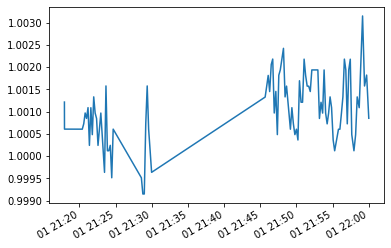

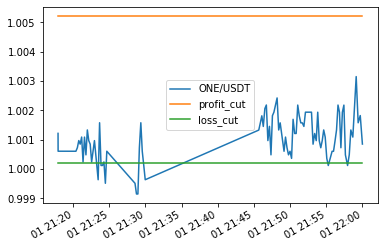

진입 현선비율: 1.0012168410805546
현재 현선비율: 1.000852099817407
[현물] ONE/USDT 현재수익률: -0.00073
[선물] ONE/USDT  현재수익률: 0.00037
[종합] ONE/USDT  현재수익률: -0.0001820824912954043
현재가 추출 완료


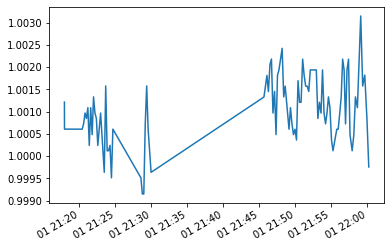

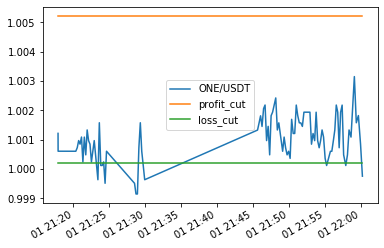

진입 현선비율: 1.0012168410805546
현재 현선비율: 0.9997560678131481
[현물] ONE/USDT 현재수익률: -0.00377
[선물] ONE/USDT  현재수익률: 0.00231
[종합] ONE/USDT  현재수익률: -0.0007278123492627361
현재가 추출 완료


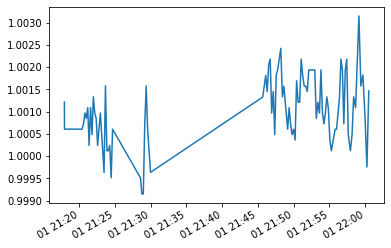

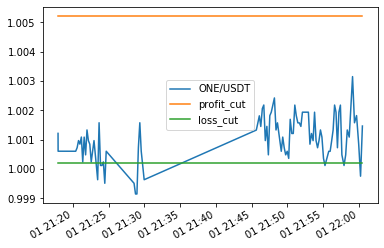

진입 현선비율: 1.0012168410805546
현재 현선비율: 1.00146717202592
[현물] ONE/USDT 현재수익률: -0.0045
[선물] ONE/USDT  현재수익률: 0.00475
[종합] ONE/USDT  현재수익률: 0.00012442007791335988
현재가 추출 완료


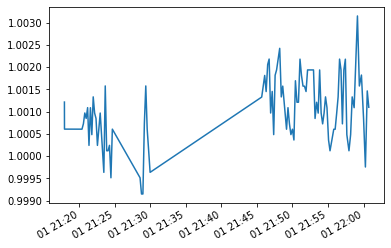

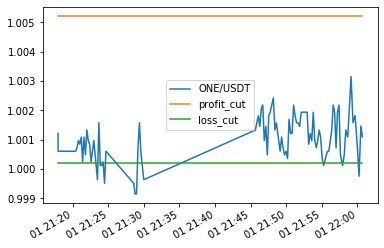

진입 현선비율: 1.0012168410805546
현재 현선비율: 1.0010999755560988
[현물] ONE/USDT 현재수익률: -0.0045
[선물] ONE/USDT  현재수익률: 0.00438
[종합] ONE/USDT  현재수익률: -5.810608416988595e-05
현재가 추출 완료


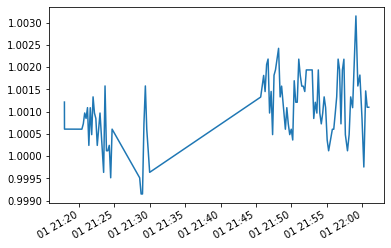

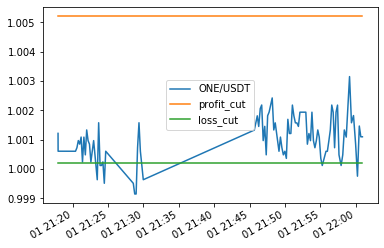

진입 현선비율: 1.0012168410805546
현재 현선비율: 1.0010999755560988
[현물] ONE/USDT 현재수익률: -0.0045
[선물] ONE/USDT  현재수익률: 0.00438
[종합] ONE/USDT  현재수익률: -5.810608416988595e-05


KeyboardInterrupt: 

In [38]:
while True : 

    ###################################### [1] 시 그 널 생 성 ##############################################
    # 약 5분마다 반복 실행
    if count % 30 == 0 :
        all_close, all_close_f, ratio, signal_neg = cal_ratio_signal(100) 

    ######################################### [2] 현 재 가 추 출 #############################################
    final_list_revised = ratio.columns.tolist()

    curr_close = pd.DataFrame.from_dict(binance.fetch_tickers())[final_list_revised].loc['close']
    curr_close_f = pd.DataFrame.from_dict(binance_f.fetch_tickers())[final_list_revised].loc['close']
    curr_ratio = curr_close / curr_close_f

    select_neg = curr_ratio[signal_neg > curr_ratio]

    balance = binance.fetch_balance()
    balance_f = binance_f.fetch_balance()
    balance_f_df = pd.DataFrame(balance_f['info']['positions']).set_index('symbol')

    neg_check_list = list(map(lambda x: x[:3], select_neg.index.tolist()))

    print('현재가 추출 완료')

    ############################################## [3] 포 지 션 진 입 #######################################

    # 현선비율 시그널 미만 목록
    for neg_check in neg_check_list :

        # 현물잔고 usdt 17 초과 / 선물잔고 usdt 17 초과 /  
        # 해당 현물 코인 포지션 13 미만인 경우 / 해당 선물 코인 미실현 수익률이 0인 경우 :
        if ( binance.fetch_balance()['USDT']['free'] > 17 ) \
        & ( binance_f.fetch_balance()['USDT']['free'] > 17 ) \
        & ( binance.fetch_balance()[neg_check]['free'] < 13) \
        & ( float(balance_f_df.loc[neg_check + 'USDT']['unrealizedProfit']) == 0 ):

            # 현물/선물 매입량 계산 (15 usdt에 맞도록)
            s_q = cal_q(curr_close, neg_check, 15)
            f_q = cal_q(curr_close_f, neg_check, 15)    

            # 현물 매수 & 선물 매도

            buy_s_log = binance.create_market_buy_order(neg_check + '/USDT', s_q)
            buy_time_log = datetime.now()
            sell_f_log = binance_f.create_market_sell_order(neg_check + '/USDT', f_q)
            sell_time_log = datetime.now()
            
            print('[진입]','[BUY 현물] ', '티커명: ', neg_check + '/USDT', ' 시점: ', buy_time_log)
            print('[진입]','[SELL 선물] ', '티커명: ', neg_check + '/USDT', ' 시점: ', sell_time_log)
            
            print('현물잔고:', binance.fetch_balance()['USDT']['free'])
            print('선물잔고:', binance_f.fetch_balance()['USDT']['free'])
            
            # 로그 기록
            total_log.append(buy_s_log)
            total_log.append(sell_f_log)

            # [현물] 가격 로그 저장
            close_save[neg_check+'/USDT'] = np.nan
            close_save.loc[datetime.now(), neg_check+'/USDT'] = buy_s_log['price']
            
            # [선물, 추가] 진입 가격 저장
            tmp_balance_df = pd.DataFrame(binance_f.fetch_balance()['info']['positions']).set_index('symbol')
            f_entry_price = float(tmp_balance_df.loc[neg_check+'USDT']['entryPrice'])
            
            # [선물] 가격 로그 저장
            close_save_f[neg_check+'/USDT'] = np.nan
            close_save_f.loc[datetime.now(), neg_check+'/USDT'] = f_entry_price
            
            # 계좌 포지션 저장
            position_list.append(neg_check)
            
            # 진압당시 시점 & 현선 비율 저장
            ratio_save[neg_check+'/USDT'] = np.nan
            ratio_save.loc[datetime.now(), neg_check+'/USDT'] = buy_s_log['price'] / f_entry_price
            
    ############################################## [4] 포 지 션 청 산 #####################################
    
     # 포지션 현선비율 익/손절기준 계산
    position_pro_loss_df = get_pro_loss_df(list(map(lambda x: x+'/USDT', position_list)))

    # 현선비율 시그널 미만 목록
    for position in position_list :
    
        if (  binance.fetch_balance()[position]['free'] > 10 ) \
        & ( float(balance_f_df.loc[position + 'USDT']['unrealizedProfit']) != 0 ):

            # 손절/익절 기준 계산 (진입 가격 기준)
            _profit_tmp_, _loss_tmp_ = \
            tmp_loss_cut(close_save[position+'/USDT'][0], close_save_f[position+'/USDT'][0])
            
            temp_s_close = binance.fetch_tickers(position+'/USDT')[position+'/USDT']['close']
            temp_f_close = binance_f.fetch_tickers(position+'/USDT')[position+'/USDT']['close']
            
            _ratio = temp_s_close / temp_f_close

            # [익절] 현물 매도 & 선물 매수
            if _ratio_ >= _profit_tmp_ :
                sell_s_log = binance.create_market_sell_order(position + '/USDT', s_q)
                sell_time_log = datetime.now()
                buy_f_log = binance_f.create_market_buy_order(position + '/USDT', f_q)
                buy_time_log = datetime.now()

                # 로그 기록
                total_log.append(sell_s_log)
                total_log.append(buy_f_log)

                print('[청산]','[SELL 현물] ', '티커명: ', position + '/USDT', ' 시점: ', sell_time_log)
                print('[청산]','[BUY 선물] ', '티커명: ', position + '/USDT', ' 시점: ', buy_time_log)

            # [손절] 현물 매도 & 선물 매수
            elif _ratio_ <= _loss_tmp_ :
                sell_s_log = binance.create_market_sell_order(position + '/USDT', s_q)
                sell_time_log = datetime.now()
                buy_f_log = binance_f.create_market_buy_order(position + '/USDT', f_q)
                buy_time_log = datetime.now()

                total_log.append(sell_s_log)
                total_log.append(buy_f_log)

                print('[청산]','[SELL 현물] ', '티커명: ', position + '/USDT', ' 시점: ', sell_time_log)
                print('[청산]','[BUY 선물] ', '티커명: ', position + '/USDT', ' 시점: ', buy_time_log)

            else :
                
                # 포지션 현재 현선비율 저장 & 누적 시각화
                temp_s_close = binance.fetch_tickers(position+'/USDT')[position+'/USDT']['close']
                temp_f_close = binance_f.fetch_tickers(position+'/USDT')[position+'/USDT']['close']

                ratio_save.loc[datetime.now(), position+'/USDT'] = temp_s_close / temp_f_close
                ratio_save[position+'/USDT'].plot()            

                # 익절 기준 및 손절 기준 시각화
                pro_loss_visualize = pd.DataFrame(ratio_save[position+'/USDT'])
                pro_loss_visualize['profit_cut'] = _profit_tmp_
                pro_loss_visualize['loss_cut'] = _loss_tmp_
                pro_loss_visualize.plot()
                plt.pause(0.05)

                # 진입당시 및 현재 현선비율 출력
                print('진입 현선비율:', str(entry_ratio_tmp))
                print('현재 현선비율:', str(temp_s_close / temp_f_close))

                # [현물] 포지션 현재 누적 수익률 계산
                close_save.loc[datetime.now(), position+'/USDT'] = temp_s_close

                s_curr_ret = ( close_save[position+'/USDT'][-1] - close_save[position+'/USDT'][0] ) \
                / close_save[position+'/USDT'][0]

                # [선물] 포지션 현재 누적 수익률 계산
                close_save_f.loc[datetime.now(), position+'/USDT'] = temp_f_close

                f_curr_ret = ( close_save_f[position+'/USDT'][0] - close_save_f[position+'/USDT'][-1]) \
                / close_save_f[position+'/USDT'][0]

                # [현물/선물/종합] 누적 수익률 출력
                print('[현물]',  position+'/USDT', '현재수익률:', round(s_curr_ret,5))
                print('[선물]', position+'/USDT', ' 현재수익률:', round(f_curr_ret,5))
                print('[종합]', position+'/USDT', ' 현재수익률:', float((s_curr_ret + f_curr_ret) / 2))
            
    count += 1
    time.sleep(10)